In [1]:
import joblib
import os
!pip install lightgbm

In [2]:
# !pip install --upgrade scikit-learn imbalanced-learn

In [3]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# --- 1. Load Data and Clean Column Names ---
df_class = pd.read_csv('../data/raw/ai4i2020.csv')

original_columns = df_class.columns
new_columns = [col.replace('[K]', '').replace('[rpm]', '').replace('[Nm]', '').replace('[min]', '').strip().replace(' ', '_').lower() for col in original_columns]
df_class.columns = new_columns

# Drop useless ID columns
df_class = df_class.drop(columns=['udi', 'product_id'])

# Define the target mapping for multi-class classification
# We will predict the specific failure type. 'No Failure' will be the majority class.
y = df_class['failure_type']
X = df_class.drop(columns=['target', 'failure_type']) # Drop both target columns

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)
print("\nTarget Class Distribution:")
print(y.value_counts())

Shape of X: (10000, 6)
Shape of y: (10000,)

Target Class Distribution:
failure_type
No Failure                  9652
Heat Dissipation Failure     112
Power Failure                 95
Overstrain Failure            78
Tool Wear Failure             45
Random Failures               18
Name: count, dtype: int64


In [5]:
# --- 2. Define Preprocessing Steps for Different Column Types ---

# Identify categorical and numerical features
categorical_features = ['type']
numerical_features = X.select_dtypes(include=np.number).columns.tolist()

# Create a preprocessing pipeline for numerical features (scaling)
numeric_transformer = StandardScaler()

# Create a preprocessing pipeline for categorical features (one-hot encoding)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # Keep other columns if any (none in this case)
)

print("Preprocessing pipeline created successfully.")
print("\nNumerical features to be scaled:", numerical_features)
print("Categorical features to be one-hot encoded:", categorical_features)

Preprocessing pipeline created successfully.

Numerical features to be scaled: ['air_temperature', 'process_temperature', 'rotational_speed', 'torque', 'tool_wear']
Categorical features to be one-hot encoded: ['type']


In [6]:
# --- 3. Split the Data ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Original training set shape:", X_train.shape)
print("Original training target distribution:\n", y_train.value_counts())
print("\n" + "="*50 + "\n")

Original training set shape: (8000, 6)
Original training target distribution:
 failure_type
No Failure                  7722
Heat Dissipation Failure      90
Power Failure                 76
Overstrain Failure            62
Tool Wear Failure             36
Random Failures               14
Name: count, dtype: int64




In [7]:
# --- 4. Apply Preprocessing ---
# Fit the preprocessor on the training data and transform both sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [8]:
# --- 5. Apply SMOTE to the Processed Training Data ---
print("Applying SMOTE to the training data...")
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

print("\nResampled training set shape:", X_train_resampled.shape)
print("Resampled training target distribution:\n", y_train_resampled.value_counts())
print("\n" + "="*50 + "\n")

Applying SMOTE to the training data...

Resampled training set shape: (46332, 8)
Resampled training target distribution:
 failure_type
No Failure                  7722
Tool Wear Failure           7722
Random Failures             7722
Power Failure               7722
Heat Dissipation Failure    7722
Overstrain Failure          7722
Name: count, dtype: int64




In [9]:
# --- 6. Train LightGBM Classifier ---
print("Training LightGBM model on resampled data...")
lgb_clf = lgb.LGBMClassifier(random_state=42)
lgb_clf.fit(X_train_resampled, y_train_resampled)

print("Model training complete.")


Training LightGBM model on resampled data...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 46332, number of used features: 8
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
Model training complete.


Evaluating model performance on the original, imbalanced test set...

Classification Report:
                          precision    recall  f1-score   support

Heat Dissipation Failure       1.00      0.95      0.98        22
              No Failure       0.99      0.99      0.99      1930
      Overstrain Failure       0.79      0.94      0.86        16
           Power Failure       0.84      0.84      0.84        19
         Random Failures       0.00      0.00      0.00         4
       Tool Wear Failure       0.00      0.00      0.00         9

                accuracy                           0.98      2000
               macro avg       0.60      0.62      0.61      2000
            weighted avg       0.98      0.98      0.98      2000


Confusion Matrix:


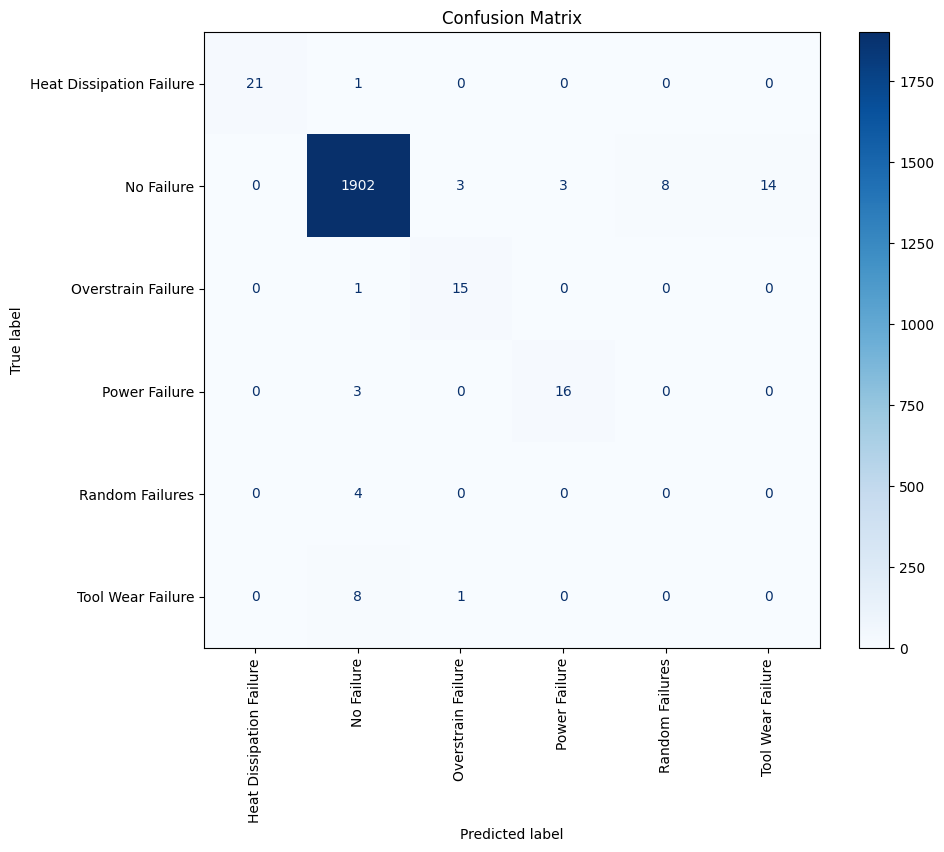

In [10]:
# --- 7. Evaluate the Model on the Unseen Test Set ---
print("Evaluating model performance on the original, imbalanced test set...")

# Make predictions
y_pred_class = lgb_clf.predict(X_test_processed)

# Get the unique class labels for plotting
class_labels = sorted(y_train.unique())

# --- Print Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_pred_class, target_names=class_labels))


# --- Plot Confusion Matrix ---
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_class, labels=class_labels)

# Use ConfusionMatrixDisplay for a nice plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# --- 8. Save the Final Model and Preprocessor ---

# Define the directory to save the model artifacts
model_dir = '../ml_models/classification'
os.makedirs(model_dir, exist_ok=True) # Create the directory if it doesn't exist

# Define file paths
classifier_path = os.path.join(model_dir, 'fault_classifier.joblib')
preprocessor_path = os.path.join(model_dir, 'classification_preprocessor.pkl')

# Save the trained LightGBM classifier
joblib.dump(lgb_clf, classifier_path)
print(f"Classifier saved to: {classifier_path}")

# Save the fitted preprocessor
joblib.dump(preprocessor, preprocessor_path)
print(f"Preprocessor saved to: {preprocessor_path}")

Classifier saved to: ../ml_models/classification\fault_classifier.joblib
Preprocessor saved to: ../ml_models/classification\classification_preprocessor.pkl
